## Импортирование библиотек и загрузка набора данных

In [1]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023.07 -- EDA и основы разработки/abalone_EDA_result.csv')
df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,I,M
0,0.455,0.365,0.095,0.514000,0.2245,0.1010,0.150,15.0,0.0,1.0
1,0.350,0.265,0.090,0.225500,0.0995,0.0485,0.070,7.0,0.0,1.0
2,0.530,0.420,0.135,0.677000,0.2565,0.1415,0.210,9.0,0.0,0.0
3,0.440,0.365,0.125,0.543789,0.2155,0.1140,0.155,10.0,0.0,1.0
4,0.330,0.255,0.080,0.205000,0.0895,0.0395,0.055,7.0,1.0,0.0


## Функции для обучения и подбора гиперпараметров

In [6]:
def train_model(algorithm,
                X,
                y,
                init_params=None,
                cat_features=None,
                random_seed=42,
                early_stopping_rounds = None,

    ):
    scores = []
    models = []
    scores_r2 = []

    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

    print(f"========= TRAINING {algorithm.__name__} =========")

    for num_fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_eval = X.iloc[train_index], X.iloc[val_index]
        y_train, y_eval = y.iloc[train_index], y.iloc[val_index]

        if init_params is not None:
            model = algorithm(**init_params)
        else:
            model = algorithm()

        if algorithm.__name__ == 'CatBoostRegressor':
            # Используйте соответствующий класс
            train_dataset = Pool(data=X_train,
                                 label=y_train,
                                 cat_features=cat_features)
            eval_dataset = Pool(data=X_eval,
                                 label=y_eval,
                                 cat_features=cat_features)

            model.fit(train_dataset,
                      eval_set=eval_dataset,
                      verbose=0,
                      early_stopping_rounds=early_stopping_rounds)
        else:
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('main_model', model)]
                             )
            model.fit(X_train, y_train)

        # Сделайте предсказание на X_eval и посчитайте RMSE
        y_pred = model.predict(X_eval)
        score_r2 = r2_score(y_eval, y_pred)
        score = mean_squared_error(y_eval, y_pred)

        models.append(model)
        scores.append(score)
        scores_r2.append(score_r2)
        print(f"FOLD {num_fold}: SCORE MSE: {round(score,3)}, \tSCORE R2: {round(score_r2, 3)}")

    mean_kfold_score = np.mean(scores, dtype="float16")
    mean_kfold_score_r2 = np.mean(scores_r2, dtype="float16")
    print("\nMEAN MSE SCORE:", mean_kfold_score)
    print("MEAN R2 SCORE:", mean_kfold_score_r2)
    # Выберите модель с наименьшим значением скора
    best_model = models[scores.index(max(scores))]

    return mean_kfold_score, best_model

In [5]:
from sklearn.model_selection import GridSearchCV

def tuning_hyperparams(algorithm,
                       X,
                       y,
                       init_params,
                       fit_params,
                       grid_params,
                       cv=3
    ):

    estimator = algorithm(**init_params)

    # Можно использоавть GridSearchCV
    model = GridSearchCV(estimator=estimator,
                         param_grid=grid_params,
                         cv=cv,
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1,
                         verbose=0,
    )

    model.fit(X, y, **fit_params)

    return model.best_params_

## Обучение на числовых признаках (NB, KNN, LineraRegression, CatBoost)

In [7]:
# выделим X для числовых признаков и целевую y
X = df.drop(['Rings', 'I', 'M'], axis=1)
y = df['Rings']

Обучим 5 моделей:
- 2 предложенных (NB и kNN)
- LinearRegression
- GradientBoostRegressor

In [8]:
NB_NoCategorical_pure = train_model(GaussianNB, X, y)

========= TRAINING GaussianNB =========
FOLD 0: SCORE MSE: 9.055, 	SCORE R2: 0.129
FOLD 1: SCORE MSE: 9.071, 	SCORE R2: 0.097
FOLD 2: SCORE MSE: 10.378, 	SCORE R2: -0.008
FOLD 3: SCORE MSE: 10.354, 	SCORE R2: -0.019
FOLD 4: SCORE MSE: 9.981, 	SCORE R2: 0.09

MEAN MSE SCORE: 9.766
MEAN R2 SCORE: 0.058


Результат модели (практически) ничем не лучше, чем предсказание среднего целевой перемнной (r2 == 0).

Причина такого плохого результата - большая скоррелированность данных. Наивная байесовская модель предполагает, что признаки незаависимы друг относительно друга, но это скорей всего не так.

Модель бы показала лучшие результаты после уменьшения размерности с помощью PCA или факторного анализа.



In [9]:
KNN_NoCategorical_pure = train_model(KNeighborsRegressor, X, y)

========= TRAINING KNeighborsRegressor =========
FOLD 0: SCORE MSE: 5.202, 	SCORE R2: 0.5
FOLD 1: SCORE MSE: 5.579, 	SCORE R2: 0.444
FOLD 2: SCORE MSE: 5.481, 	SCORE R2: 0.468
FOLD 3: SCORE MSE: 4.955, 	SCORE R2: 0.512
FOLD 4: SCORE MSE: 5.851, 	SCORE R2: 0.467

MEAN MSE SCORE: 5.414
MEAN R2 SCORE: 0.478


Как и ожидалось, К ближайших соседей значительно лучше, чем наивная байесовская модель (метрика r2 многократно выросла).

Предположительно это связано с тем, что модель лучше подходит для сильно скоррелированных данных.

In [10]:
EN_NoCategorical_pure = train_model(ElasticNet, X, y)

========= TRAINING ElasticNet =========
FOLD 0: SCORE MSE: 6.541, 	SCORE R2: 0.371
FOLD 1: SCORE MSE: 6.487, 	SCORE R2: 0.354
FOLD 2: SCORE MSE: 6.998, 	SCORE R2: 0.32
FOLD 3: SCORE MSE: 6.615, 	SCORE R2: 0.349
FOLD 4: SCORE MSE: 7.584, 	SCORE R2: 0.309

MEAN MSE SCORE: 6.844
MEAN R2 SCORE: 0.3406


Результат линейной регрессионной модели (даже без регуляризаций) превосходит качество NB, но хуже KNN. Архитектура модели больше подходит для обобщения связи между признаками и целевой переменной, чем модель NB. Однако из-за дефолтный параметров по умолчанию метрики хуже, чем KNN.

Предполагаю, что при тюнинге ElasticNet будет лучше, чем KNN.

На последок посмотрим, как будет вести себя GradientBoosting.



In [27]:
GBR_NoCategorical_pure = train_model(GradientBoostingRegressor, X, y, init_params={'random_state': 42})

========= TRAINING GradientBoostingRegressor =========
FOLD 0: SCORE MSE: 4.457, 	SCORE R2: 0.571
FOLD 1: SCORE MSE: 5.077, 	SCORE R2: 0.494
FOLD 2: SCORE MSE: 4.815, 	SCORE R2: 0.532
FOLD 3: SCORE MSE: 4.293, 	SCORE R2: 0.578
FOLD 4: SCORE MSE: 5.451, 	SCORE R2: 0.503

MEAN MSE SCORE: 4.82
MEAN R2 SCORE: 0.536


1. Наивная байесовская модель дала результаты хуже, чем среднее (метрика r2 примерно равна 0). Ожидаемо, так как она предполагает, что признаки независимы (а в дата сете признаки сильно скоррелированны). Пожалуй это самая неподходящая архитектура модели для данного набора данных.

2. KNN - значительно лучше NB (r2 хотя бы не отрицательная). Однако архитектура модели довольно простая, скорей всего используя другую модель можно получить сильно лучшие результаты.

3. ElasticNet - дала результат лучше, чем NB, но хуже, чем KNN. Я ожидал лучшего результата от линейной модели, так как признаки сильно линейно связаны с таргетом. Думаю, что после тюнинга качество модели должно сильно возрасти.

4. GradientBoostingRegressor оказался лучше всех моделей (KNN немного до него недотянул). Я так и предполагал: модель состоит из ансамбля деревьев, одной из самых популярных и сильных архитектур классического ML (не просто так существуют CatBoost, LGBM и XGBoost). Предполагаю, что и после подбора гиперпараметров модель так же будет показывать наилучшие результаты среди перечисленных выше моделей.

## Подбор гиперпараметров (NB, KNN, LineraRegression, CatBoost)

### GaussianNB

In [11]:
# без тюнинга было:
# MEAN MSE SCORE: 9.766
# MEAN R2 SCORE: 0.058
tmp_params = {}
best_params_NB = tuning_hyperparams(GaussianNB, X, y,
                                   init_params=tmp_params,
                                   fit_params=tmp_params,
                                   grid_params={'var_smoothing': np.linspace(pow(10, -15), pow(10, -7), 100)})
print('best_params', best_params_NB)
NG_NoCategorical_tune = train_model(GaussianNB, X, y, init_params=best_params_NB)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


best_params {'var_smoothing': 1.0101019999999999e-09}
========= TRAINING GaussianNB =========
FOLD 0: SCORE MSE: 9.055, 	SCORE R2: 0.129
FOLD 1: SCORE MSE: 9.071, 	SCORE R2: 0.097
FOLD 2: SCORE MSE: 10.378, 	SCORE R2: -0.008
FOLD 3: SCORE MSE: 10.354, 	SCORE R2: -0.019
FOLD 4: SCORE MSE: 9.981, 	SCORE R2: 0.09

MEAN MSE SCORE: 9.766
MEAN R2 SCORE: 0.058


Ни одна из метрик (MSE и R2) не изменилась. Подбор гиперпараметров ничего не дал для этой архитектуры модели. Повторюсь: это наиболее плохая архитектура для решения задачи.

### KNeighborsRegressor

In [12]:
# без тюнинга было:
# MEAN MSE SCORE: 5.414
# MEAN R2 SCORE: 0.478
tmp_params = {}
best_params_KNN = tuning_hyperparams(KNeighborsRegressor, X, y,
                                   init_params=tmp_params,
                                   fit_params={},
                                   grid_params={'n_neighbors': np.arange(1,100,1)})
print('best_params', best_params_KNN)
KNN_NoCategorical_tune = train_model(KNeighborsRegressor, X, y, init_params=best_params_KNN)

best_params {'n_neighbors': 14}
========= TRAINING KNeighborsRegressor =========
FOLD 0: SCORE MSE: 4.74, 	SCORE R2: 0.544
FOLD 1: SCORE MSE: 5.137, 	SCORE R2: 0.489
FOLD 2: SCORE MSE: 4.777, 	SCORE R2: 0.536
FOLD 3: SCORE MSE: 4.5, 	SCORE R2: 0.557
FOLD 4: SCORE MSE: 5.386, 	SCORE R2: 0.509

MEAN MSE SCORE: 4.906
MEAN R2 SCORE: 0.527


Качество модели немного возросло (практически достигло качества GradientBoosting).
- MSE уменьшилась на 10 %
- R2 возрасла на 10.7%

### ElasticNet (LinearRegression с регуляризацией)

In [13]:
# без тюнинга было:
# MEAN MSE SCORE: 6.844
# MEAN R2 SCORE: 0.3406

# подбирать гиперпараметры стандартной линейной модели - странная затея
# решил использовать ElasticNet (та же линейная, просто с регуляризациями)

tmp_params = {}
best_params_LR = tuning_hyperparams(ElasticNet, X, y,
                                     init_params=tmp_params,
                                     fit_params=tmp_params,
                                     grid_params={'fit_intercept': [True, False],
                                                  'alpha': np.arange(0.01,3,0.1),
                                                  'l1_ratio': np.arange(0.01,1,0.1),
                                                  'selection': ['cyclic', 'random']})
print('best_params', best_params_LR)
EN_NoCategorical_tune = train_model(ElasticNet, X, y, init_params=best_params_LR)

best_params {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.91, 'selection': 'cyclic'}
========= TRAINING ElasticNet =========
FOLD 0: SCORE MSE: 4.554, 	SCORE R2: 0.562
FOLD 1: SCORE MSE: 4.792, 	SCORE R2: 0.523
FOLD 2: SCORE MSE: 5.051, 	SCORE R2: 0.51
FOLD 3: SCORE MSE: 4.504, 	SCORE R2: 0.557
FOLD 4: SCORE MSE: 5.424, 	SCORE R2: 0.506

MEAN MSE SCORE: 4.867
MEAN R2 SCORE: 0.5312


ИСпользование параметров регуляризации значительно увеличило качество линейной модели.
- метрика MSE уменьшилась на (1-4,867/6,844) = 30%
- метрика R2 возрасла на (0,5312/0,3406-1) = 56%


### GradientBoostingRegressor + optuna


Для подбора гиперпараметров у градиентного бустинга логичнее использовать optuna, так как количество гиперпараметров огромное, каждый из них может сильно влиять на архитекруту и на обобщающую способность (особенно параметры, связанные с регуляризацией).

Оценивать модель будемс помощью cross_val_score и scoring = neg_root_mean_squared_error

In [14]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


In [15]:
import optuna
from sklearn.model_selection import cross_val_score

Так как я заметил, что регуляризация тут очень сильно помогает (налицо проблема мультиколлиниарности признаков), буду перебирать высокие значения резуляризационных параметров (min_samples_split, min_samples_leaf) и малые значения гиперпараметров subsample и max_features (установлю в log2) для увеличения обобщающей способности модели.

Количество деревев ограничим 300 (x3 относительно стандартного значения) для +- ускоренного поиска.

In [16]:
def objectve(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    subsample = trial.suggest_float("subsample", 0.2, 1)
    min_samples_split = trial.suggest_int("min_samples_split", 10, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 30)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    # max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2', None])
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 10, 20)
    # criterion = trial.suggest_categorical("criterion", ['friedman_mse', 'squared_error'])
    loss = trial.suggest_categorical("loss", ['squared_error', 'absolute_error', 'huber', 'quantile'])

    score = cross_val_score(GradientBoostingRegressor(max_depth=max_depth,
                                                      learning_rate=learning_rate,
                                                      n_estimators=n_estimators,
                                                      subsample=subsample,
                                                      min_samples_split=min_samples_split,
                                                      min_samples_leaf=min_samples_leaf,
                                                      max_features='log2',
                                                      max_leaf_nodes=max_leaf_nodes,
                                                      # criterion=criterion,
                                                      loss=loss
                                                      ),
                            X, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [ ]:
# убираем log оптуны при обучении
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objectve, n_trials=300, n_jobs=-1)

print(study.best_params)
print(study.best_value)

{'learning_rate': 0.027450414665429333, 'n_estimators': 253, 'subsample': 0.35242473165115074, 'min_samples_split': 26, 'min_samples_leaf': 28, 'max_depth': 12, 'max_leaf_nodes': 20, 'loss': 'squared_error'}
-4.709879137749465


In [18]:
# без подбора гиперпараметров:
# MEAN MSE SCORE: 4.824
# MEAN R2 SCORE: 0.535

#init_params_1 = {'learning_rate': 0.027450414665429333, 'n_estimators': 253,
#                  'subsample': 0.35242473165115074, 'min_samples_split': 26,
#                  'min_samples_leaf': 28, 'max_depth': 12, 'max_leaf_nodes': 20,
#                  'loss': 'squared_error'}

GBR_NoCategorical_tune = train_model(GradientBoostingRegressor, X, y, init_params=study.best_params)

========= TRAINING GradientBoostingRegressor =========
FOLD 0: SCORE MSE: 4.256, 	SCORE R2: 0.591
FOLD 1: SCORE MSE: 4.78, 	SCORE R2: 0.524
FOLD 2: SCORE MSE: 4.555, 	SCORE R2: 0.558
FOLD 3: SCORE MSE: 4.126, 	SCORE R2: 0.594
FOLD 4: SCORE MSE: 4.906, 	SCORE R2: 0.553

MEAN MSE SCORE: 4.523
MEAN R2 SCORE: 0.5635


Результат немного, но увеличился. Как и предполагалось, градиентный бустинг с подобранными гиперпараметрами сильнее, чем KNN.

- метрика MSE выросла на (1 - 4.555/4.824) = 5.5%
- метрика R2 выросла на (0.561/0.535)-1 = 5%

1. Подбор гиперпараметров для NG не дал ничего полезного (да и гиперпараметров мало для подгона и значительного увеличения качества). Модель не подходит для решения данной задачи.
2. KNN после подбора гиперпараметров увеличила значения метрик на 10%. Подбирался только один гиперпараметр - количество ближайших соседей. Таким образом она сравнялась по качеству с градиентным бустингом без тюнинга.
3. Линейная модель (ElasticNet) значительно увеличила качество после подбора гиперпараметров, которые в основном сильнее регуляризовали модель (l1 -> 1, следовательно модель использовала скорее l1 регуляризацию, стараясь занулить веса при коэффициентах). Значения метрик MSE и R2 возрасли на 30% и 50% соответственно.
4. Подбор гиперпараметров для GradientBoostingRegressor осуществлялся с помощью фреймворка optuna. Не смотря на всего 300 точек перебора время подбора превысило 12 минут. Результат: немного вырасло качество. Модель все так же является лучшей по метрикам для решения поставленной задачи при подборе гиперпараметров.

## Добавление категориальных признаков и обучение с параметрами по умолчанию

In [30]:
# выделим X для числовых признаков и целевую y
# категориальным признаком является лишь один  - гендер.
# до построения моделей признак уже был преобразован с помощью OneHotEncoding
# Так как признак принимает 3 возможных значения (M, F, I), признак кодируется 2мя столбцами: I и M
X = df.drop(['Rings'], axis=1)
y = df['Rings']
X.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,I,M
0,0.455,0.365,0.095,0.514000,0.2245,0.1010,0.150,0.0,1.0
1,0.350,0.265,0.090,0.225500,0.0995,0.0485,0.070,0.0,1.0
2,0.530,0.420,0.135,0.677000,0.2565,0.1415,0.210,0.0,0.0
3,0.440,0.365,0.125,0.543789,0.2155,0.1140,0.155,0.0,1.0
4,0.330,0.255,0.080,0.205000,0.0895,0.0395,0.055,1.0,0.0


Сравнивать значения метрик каждой модели будем между собой и между сооветствующими моделями без подбора гиперпараметров и учета категориальных признаков.

In [31]:
NB_categoricat_pure = train_model(GaussianNB, X, y)

========= TRAINING GaussianNB =========
FOLD 0: SCORE MSE: 85.844, 	SCORE R2: -7.254
FOLD 1: SCORE MSE: 84.074, 	SCORE R2: -7.372
FOLD 2: SCORE MSE: 59.279, 	SCORE R2: -4.756
FOLD 3: SCORE MSE: 70.454, 	SCORE R2: -5.933
FOLD 4: SCORE MSE: 44.861, 	SCORE R2: -3.089

MEAN MSE SCORE: 68.9
MEAN R2 SCORE: -5.68


In [32]:
# MEAN MSE SCORE: 5.414
# MEAN R2 SCORE: 0.478
KNN_categoricat_pure = train_model(KNeighborsRegressor, X, y)

========= TRAINING KNeighborsRegressor =========
FOLD 0: SCORE MSE: 5.153, 	SCORE R2: 0.505
FOLD 1: SCORE MSE: 5.678, 	SCORE R2: 0.435
FOLD 2: SCORE MSE: 5.488, 	SCORE R2: 0.467
FOLD 3: SCORE MSE: 5.021, 	SCORE R2: 0.506
FOLD 4: SCORE MSE: 5.681, 	SCORE R2: 0.482

MEAN MSE SCORE: 5.402
MEAN R2 SCORE: 0.479


KNN практически никак не изменила свое качество при введении новых переменных, кодирующий единственный категориальный признак - гендер (принимающий 3 значения).

Результат, как и ожидалось, значительно лучше NB

In [33]:
# MEAN MSE SCORE: 6.844
# MEAN R2 SCORE: 0.3406
EN_categoricat_pure = train_model(ElasticNet, X, y)

========= TRAINING ElasticNet =========
FOLD 0: SCORE MSE: 6.471, 	SCORE R2: 0.378
FOLD 1: SCORE MSE: 6.43, 	SCORE R2: 0.36
FOLD 2: SCORE MSE: 6.939, 	SCORE R2: 0.326
FOLD 3: SCORE MSE: 6.533, 	SCORE R2: 0.357
FOLD 4: SCORE MSE: 7.52, 	SCORE R2: 0.315

MEAN MSE SCORE: 6.773
MEAN R2 SCORE: 0.3472


При добавлении нового категориального признака качетство моедли незначительно возрасло:
- MSE уменьшилась на 1 - 0.6733/0.6844 = 2%
- R2 увеличилась на 0.3472/0.3406 - 1 = 2%

Результат все так же, как и без категориальных параметров: хуже, чем у KNN и значительно лучше, чем у NB.

In [34]:
# MEAN MSE SCORE: 4.824
# MEAN R2 SCORE: 0.535

GBR_categoricat_pure = train_model(GradientBoostingRegressor, X, y, init_params={'random_state': 42})

========= TRAINING GradientBoostingRegressor =========
FOLD 0: SCORE MSE: 4.351, 	SCORE R2: 0.582
FOLD 1: SCORE MSE: 5.057, 	SCORE R2: 0.496
FOLD 2: SCORE MSE: 4.724, 	SCORE R2: 0.541
FOLD 3: SCORE MSE: 4.221, 	SCORE R2: 0.585
FOLD 4: SCORE MSE: 5.137, 	SCORE R2: 0.532

MEAN MSE SCORE: 4.695
MEAN R2 SCORE: 0.5474


Так же как линейная модель, GradientBoostRegressor немного увеличил качество предсказывания по обеим метрикам.
- MSE уменьшилась на  1 - 0.47/0.48 = 2.5%
- R2 увеличилась на 0.55/0.535 - 1 = 2.1%

1. NB плохо себя показала и с категориальным признаком (genfer).
2. Качество KNN практически никак не увеличилось при добавлении категориального признака.
3. Качество линейной регрессионной модели с параметрами по умолчанию возрасло на 2% по сравнению с такой же моделью без категориального признака. Все так же модель увеленно отстает от KNN без регуляризации (тюнинга).
4. Качество градиентного бустинга незначительно (на 2%) увеличилось при добавлении категориального параметра. Модель так же остается лучшей при использовании значений гиперпараметров по умолчанию.

## Тюнинг с использованием категориальных признаков

### NB с признаком gender

In [ ]:
# без тюнинга было:
# MEAN MSE SCORE: 68.9
# MEAN R2 SCORE: -5.68
tmp_params = {}
best_params_NB = tuning_hyperparams(GaussianNB, X, y,
                                   init_params=tmp_params,
                                   fit_params=tmp_params,
                                   grid_params={'var_smoothing': np.linspace(pow(10, -15), pow(10, -7), 100)})
print('best_params', best_params_NB)
NG_Categorical_tune = train_model(GaussianNB, X, y, init_params=best_params_NB)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


best_params {'var_smoothing': 1e-07}
========= TRAINING GaussianNB =========
FOLD 0: SCORE MSE: 81.315, 	SCORE R2: -6.818
FOLD 1: SCORE MSE: 77.662, 	SCORE R2: -6.733
FOLD 2: SCORE MSE: 53.327, 	SCORE R2: -4.178
FOLD 3: SCORE MSE: 62.565, 	SCORE R2: -5.157
FOLD 4: SCORE MSE: 40.512, 	SCORE R2: -2.692

MEAN MSE SCORE: 63.1
MEAN R2 SCORE: -5.117


Незначительное увеличение качества.

### KNN с учетом признака gender

In [ ]:
# без тюнинга было:
# MEAN MSE SCORE: 5.402
# MEAN R2 SCORE: 0.479

# после тюнинга без gender:
# MEAN MSE SCORE: 4.906
# MEAN R2 SCORE: 0.527

tmp_params = {}
best_params_KNN = tuning_hyperparams(KNeighborsRegressor, X, y,
                                   init_params=tmp_params,
                                   fit_params={},
                                   grid_params={'n_neighbors': np.arange(1,100,1)})
print('best_params', best_params_KNN)
KNN_Categorical_tune = train_model(KNeighborsRegressor, X, y, init_params=best_params_KNN)

best_params {'n_neighbors': 15}
========= TRAINING KNeighborsRegressor =========
FOLD 0: SCORE MSE: 4.573, 	SCORE R2: 0.56
FOLD 1: SCORE MSE: 5.024, 	SCORE R2: 0.5
FOLD 2: SCORE MSE: 4.918, 	SCORE R2: 0.522
FOLD 3: SCORE MSE: 4.551, 	SCORE R2: 0.552
FOLD 4: SCORE MSE: 5.065, 	SCORE R2: 0.538

MEAN MSE SCORE: 4.824
MEAN R2 SCORE: 0.5347


Качество возрасло:
- MSE уменьшилась на 1 - 5/5.402 =
- R2 увеличилась на 0.518/0.479 - 1 =
Оптимальное количество соседей увеличилось на 1.

Относильно тюнинга без признака gender качество немного возрасло (что говорит о пользе использования этого признака в итоговой модели).

### ElasticNet с учетом признака gender

In [ ]:
# без тюнинга было:
# MEAN MSE SCORE: 6.773
# MEAN R2 SCORE: 0.3472

# после тюнинга без gender:
# MEAN MSE SCORE: 4.867
# MEAN R2 SCORE: 0.5312

tmp_params = {}
best_params_LR = tuning_hyperparams(ElasticNet, X, y,
                                     init_params=tmp_params,
                                     fit_params=tmp_params,
                                     grid_params={'fit_intercept': [True, False],
                                                  'alpha': np.arange(0.01,3,0.1),
                                                  'l1_ratio': np.arange(0.01,1,0.1),
                                                  'selection': ['cyclic', 'random']})
print('best_params', best_params_LR)
EN_NoCategorical_tune = train_model(ElasticNet, X, y, init_params=best_params_LR)

best_params {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.91, 'selection': 'cyclic'}
========= TRAINING ElasticNet =========
FOLD 0: SCORE MSE: 4.797, 	SCORE R2: 0.539
FOLD 1: SCORE MSE: 5.128, 	SCORE R2: 0.489
FOLD 2: SCORE MSE: 5.416, 	SCORE R2: 0.474
FOLD 3: SCORE MSE: 4.84, 	SCORE R2: 0.524
FOLD 4: SCORE MSE: 5.874, 	SCORE R2: 0.465

MEAN MSE SCORE: 5.21
MEAN R2 SCORE: 0.498


Как и при тюнинге без параметра gender, качество модели значительно возрасло:
- MSE уменьшилось на 1 - 4.777/0.6773 = 30%
- R2 увеличилась на 0.54/0.3472 - 1 = 55%

При добавлении признака gender и тюнинге гиперпараметров качество модель также немного возрасло (на пару процентов).

### GradientBoostingRegressor и Optuna с учетом признака gender.

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_2 = optuna.create_study(direction="maximize", pruner=optuna.pruners.SuccessiveHalvingPruner())
study_2.optimize(objectve, n_trials=300, n_jobs=-1)

print(study_2.best_params)
print(study_2.best_value)

{'learning_rate': 0.021400373461055576, 'n_estimators': 292, 'subsample': 0.34953272585653944, 'min_samples_split': 16, 'min_samples_leaf': 18, 'max_depth': 12, 'max_leaf_nodes': 18, 'loss': 'squared_error'}
-4.620642835109554


In [37]:
# до тюнинга с признаком gender
# MEAN MSE SCORE: 4.703
# MEAN R2 SCORE: 0.5464

# после тюнинга без gender:
# MEAN MSE SCORE: 4.555
# MEAN R2 SCORE: 0.561

init_params_2 = {'learning_rate': 0.021400373461055576, 'n_estimators': 292,
                 'subsample': 0.34953272585653944, 'min_samples_split': 16,
                 'min_samples_leaf': 18, 'max_depth': 12,
                 'max_leaf_nodes': 18, 'loss': 'squared_error'}


GBR_Categorical_tune = train_model(GradientBoostingRegressor, X, y, init_params=init_params_2)

========= TRAINING GradientBoostingRegressor =========
FOLD 0: SCORE MSE: 4.181, 	SCORE R2: 0.598
FOLD 1: SCORE MSE: 4.813, 	SCORE R2: 0.521
FOLD 2: SCORE MSE: 4.494, 	SCORE R2: 0.564
FOLD 3: SCORE MSE: 4.025, 	SCORE R2: 0.604
FOLD 4: SCORE MSE: 4.804, 	SCORE R2: 0.562

MEAN MSE SCORE: 4.46
MEAN R2 SCORE: 0.5693


Качество ансамблевого метода возрасло. По сравнению с обучением со стандартными моделями, при тюнинге:
- MSE уменьшился на 6%
- R2 увеличился на 2%
Относительно тюнинга без gender, модель так же стала лучше. Данный результат является наилучшим среди всех подобраных моделей со всеми перебраными комбинациями гиперпараметров.


1. NB все так же плоха.
2. KNN показада аналогичное поведение при тюнинге, как без использования признака gender. Увеличение качества на +- 10%. Оптимальное количество ближайших соседей возрасло на 1.
3. Линейная модель показала аналогичное поведение при тюнинге, как без использования параметра gender. Значительное увелничение качества (на 30% и 50%). Сами значения гиперпараметров такие же, как при их подборе без использования признака gender.
4. Как и ожидалось, GradientBoostingRegressor оказалось лучшей моделью при подборе гиперпараметров среди ElasticNet, KNN и NB. Хотя качество и незначительно (на 2-6%) возрасло, учитывая, что оценка производилась с помощью KFOld валидации, эти 2% однозначно говорят о улучшении модели.



## Создание dachboard

In [38]:
!pip install explainerdashboard -q

In [39]:
from explainerdashboard import ExplainerDashboard, RegressionExplainer

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [40]:
explainer = RegressionExplainer(GBR_Categorical_tune[1], X.iloc[:40], y.iloc[:40])

splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [41]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.


Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [42]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# сохранение дашборда в файл:
explainer.dump('dashboard.joblib')

## Анализ дашборда:

### Анализ важности признаков

#### Наиболее важны параметры (по убыванию на основе mean absolute shap-values):
1. Shell weight
2. Shucked weight

Затем идет спад shap значения в 2 раза (с 1,2 до 0,6)

3. Whole weight
4. Height
5. I

Затем снова спад (на +- 30%)

6. Diameter
7. Length
8. M


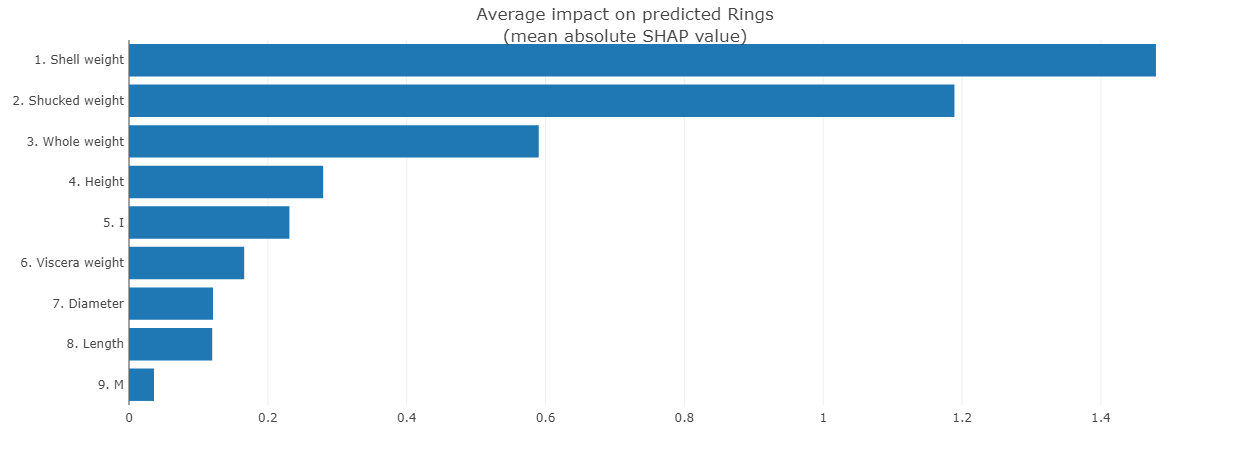

#### На основании permutation importance по метрике r2:
Разделение признаков еще более четкое. Значительно важнее первые 3 признака, совпадающие с ранжированием по shap:
1. Shell weight
2. Shucked weight
3. Whole weight

Со значительно меньшим положительным вкладом в модель на 4 месте по важности стоит Diameter.

Остальные признаки имеют отрицательные значения permutation importance, что говорит об улучшении метрик при перемешиваниии значений данных признаков. Это свидетельствует о крайне низкой важности признаков для обученной модели.


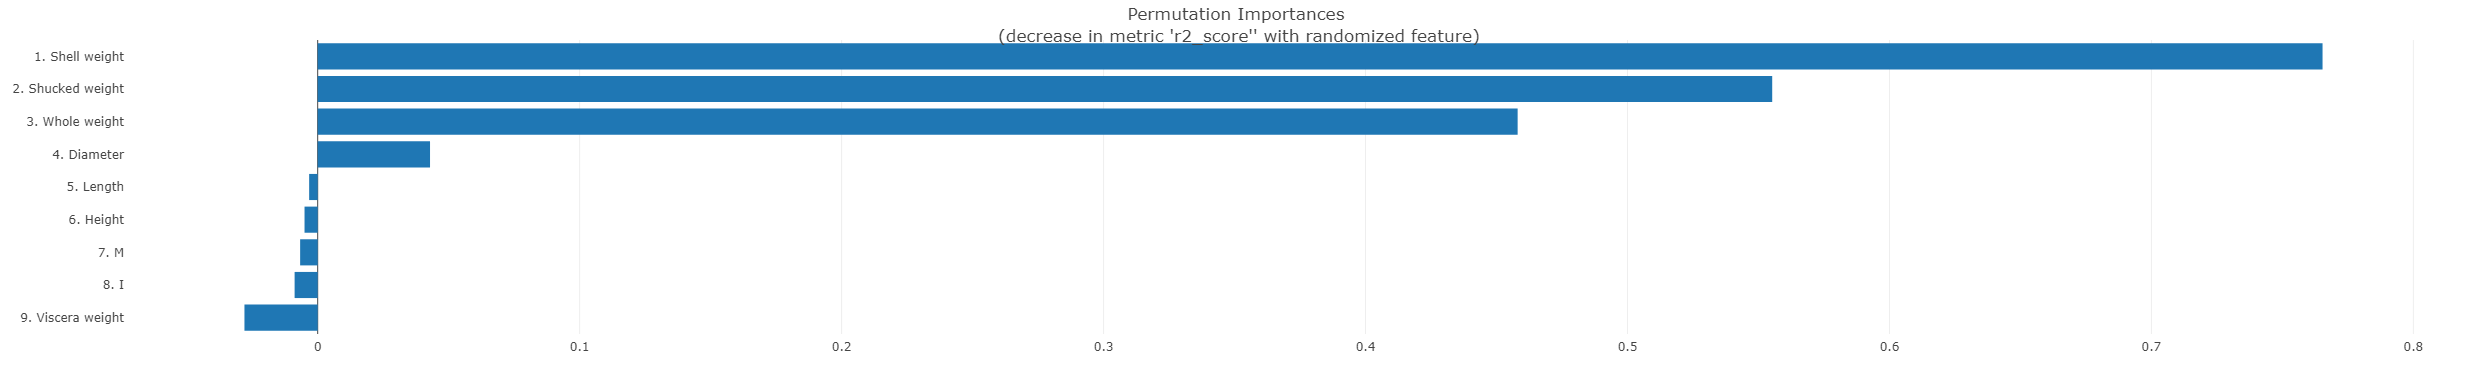

Таким образом САМЫЕ важные 2 признака для модели: Shell weight, Shucked weight.

Важность признака Diameter довольно спорна (permutation importance подвержен случайности в зависимости от перемешивания и не забываем, что признаки в датасете сильно скорелированны). Если бы я решал, какие признаки удалить (не собирать) - предварительно отдельно бы пообучал разные архитектуры моделей с этим признаком и без него и сделал бы вывод на основе результатов.

Далее идут 2 признака с меньшей важностью: Whole weight, Height, I.

Остальные признаки я бы не стал включать в модель (предполагая, что качество метрик при исключении признаков упадет незначительно и будет находится в пределах разброса метрик при KFold валидации с 3мя фолдами.

Отмечу, что признак I должен быть более значим, чем M, так как I отображает младенца, а 0 в этом признаке - взрослого. Это напрямую связано с целевой переменной (возрастом). Во время EDA male и female были сильно смешаны и не несли такую информативность. Это лишний раз доказывает, что permutation importance менее точный метод оценки информативности признаков, чем shap-values.


### Анализ значения метрик

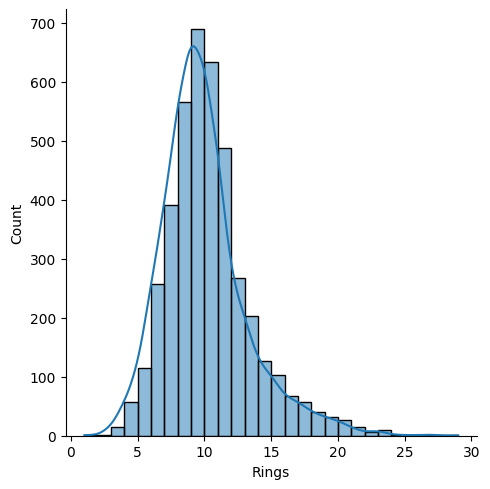

In [60]:
import seaborn as sns
sns.displot (y, kde= True, bins=len(y.unique()));

#### metric	Score
1. mean-squared-error	----------------------- 6.341
2. root-mean-squared-error	---------------- 2.518
3. mean-absolute-error	----------------------- 1.747
4. mean-absolute-percentage-error	---- 0.136
5. R-squared	---------------------------------------- 0.474

#### MSE, RMSE, MAE - средняя квадратичная ошибка и корень из нее
Имеют несколько иные значения, чем при KFold валидации во время построения модели - странно, но предполагаю, что я использовал менее интеллектуальный инструмент, чем dashboard.

По значению MSE трудно что-то сказать, а RMSE = 2.518. Следовательно в среднем модель ошибается на 2,5 кольца. Так как в среднем rings = 10, модель ошибается примерно на 25% (что довольно много). Но нужно учитывать, что MSE (и RMSE) из-за возведения в квадрат подчеркивает сильные отклонения и сглаживает небольшие. Поэтому выражение про 25% не совсем верно.

MAE значительно ниже - 1.7. Как видим, значение ниже, чем RMSE (а их можно друг с другом сравнивать, т.к. размерность одинаковая). Так как RMSE > MAE, это говорит о бОльшем количестве (или больших значениях, среднее же сильно от выбросов зависит) больших отклонений (когда отклонение >1 и RMSE его увеличивает, возводя в квадрат), чем маленьких (когда отклонение < 1 и RMSE сглаживает его, возводя в квадрат).

#### MAPE
Захотелось ее отдельно выделить, хотя она и подобна вышеописаным метрикам. Судя по значению среднем модель ошибается на 13%, что от идеального среднего предсказания (9.9) составляет 1,29 колец. Хороший результат (особенно учитывая высокую корелляцию между признаками и не нормальное распределение целевой переменной.

#### R2
Метрика показывает, на сколько модель лучше простого предскзаания среднего (1 - идеальное предсказание, 0 - ничем не отличается от mean).Я руководствовался как MSE, так и R2 на протяжении всего анализа, так как по R2 можно не зная значений целевой переменной судить о качестве модели.

Результат хороший (опять же учитывая скоррелированность признаков). Предположительно, если использовать более сложные бустинги, можно из данных выбить скор 0,6 по R2.


### Индивидуальные предсказания. Анализ.

#### Объект с индексом 3

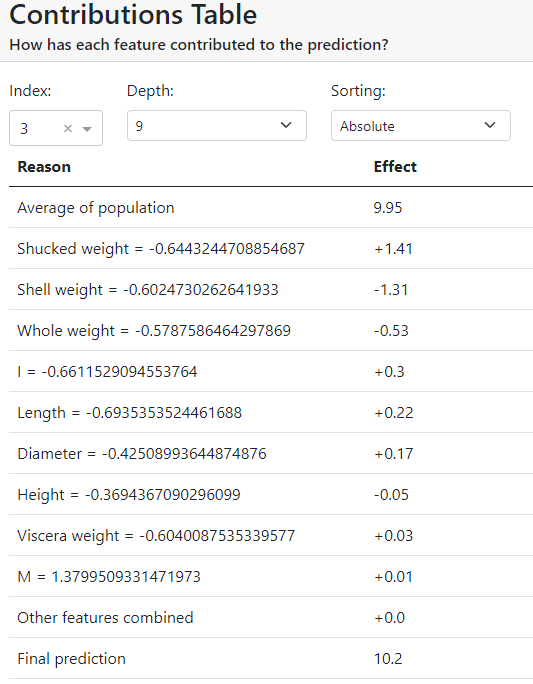

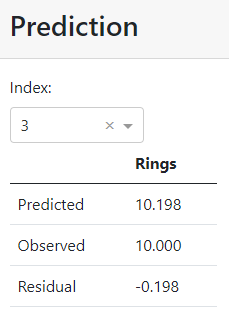

При анализе индекса объекта под иднексом 3 видим, что 3 признака, выделенные мной как самые важные, вносят наибольший вклад в значение (точнее в отклонение от среднего).

Результирующее значение немнгого завышено относительно реального (на 0,198).

#### Объект с индексом 32

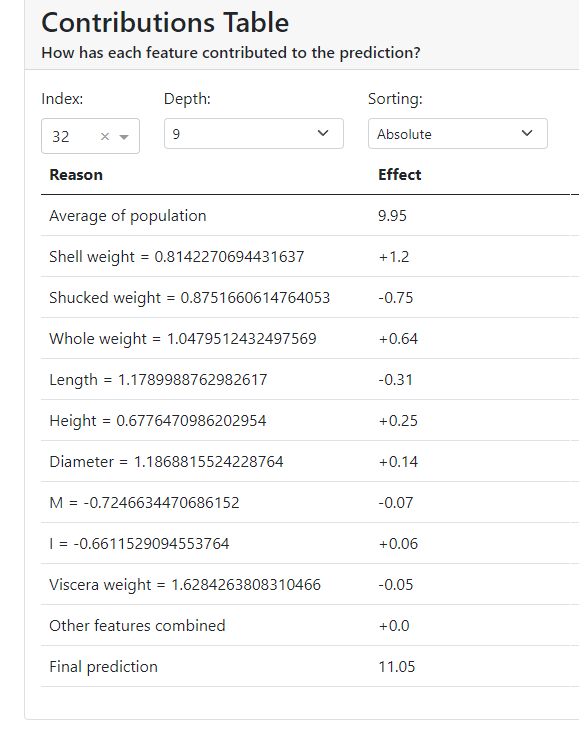

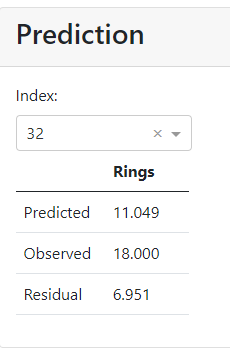

Проанализируем пример с большим отклонением от реального значения. Истинное значение y = 18, но предсказалось 11.

Также можно наблюдать, что наибольшее влияние оказали именно выделенные мной признаки (Shell weight, Shucked weight, Whole weight).

Однако можно заметить, что то, насколько эти признаки влияют на прогноз не сильно отличается от предыдущего объекта с индексом 3. В данном прмере модель "регрессировала к среднему" что и дало такой плохой результат.

## Вывод
Я взял 4 модели (NB, KNN, ElasticNet и GradientBoostingRegressor).

Обучал каждую из 4х моделей с/без подбором гиперпараметров и с/без учетом категориального признака (в датасете он только один - gender).

Как и предполагалась, лучшие результаты у каждой модели наблюдались при подборе гиперпараметров и учете категориальных признаков. Разница варировалась от 1-2% до 30-50% (в случае elasticNet, что объясняется необходимостью регуляризации при сильной скорелированности признаков).

Было доказано,
- что модель NB совсем не подходит для решения данной задачи;
- KNN показывает себя неплохо и без подбора гиперпараметров;
- ElasticNet также неплохо (лучше KNN при тюнинге) решает поставленную задачу. Модель хорошо подходит для решения задачи, так как корреляция (линейная связь) сильна между практически каждым признаком и целевой переменной. А регуляризация значительно уменьшает проблему мультиколлинеарности;
- GradientBoostingRegressor - очевидно лучшая модель как без подбора гиперпараметров, так и после него. Причина - сложная ансамблевая модель с большими возможностями по регуляризации и исправлению ошибок (бустинг по своей сути).

Был построен dashboard, проанализированы важность признаков, метрики, и пара индивидуальных предсказаний.

Предполагаемые мной проблемы еще на EDA подтвердились и влияли на результат.

Для построения итогоговой модели и наилучшего предсказания я бы провел факторный анализ (или хотя бы PCA, так как имею мало знаний закономерностей в определении возраста ракушек). Также использовал бы какой-нибудь фреймворк бустинга (LGBM скорей всего, он хорошо с регуляризацией и отбрасыванием плохих признаков работает, CatBoost вряд-ли, его фишка с категориальными признаками тут слабо влияет, так как признак такой всего один). Еще бы попробовал смешать результаты бустинга и линейной с регуляризацией (уж очень хорошо она подходит для решения задачи), может еще KNN. Думаю, можно было бы достигнуть r2 > 0.6.
